# Metropolis Hastings

## Part A: MH Proposals and Acceptance Probabilities

> *Starting with a very general notation...*

Accepting draws from a ***proposal distribution*** 

$\tilde x^{(t)} \sim q(\tilde x^{(t)}|x^{(t-1)})$

according to 

$x^{(t)} = \left\{\begin{array}{ll}
\tilde x^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})}\right) \quad \color{gray}{\begin{array}{c}\textrm{... is the normalizing constant needed for $p$?}\\\textrm{... and what happens if $q$ is symmetric?}  \end{array}}\\
x^{(t-1)} & \text{otherwise}
\end{array}\right.$

will produce draws from $p(x^{(t)})$.

### This is a two step conditional process 

$
\begin{align*}
&\quad\, \Pr(\textrm{accept}|\textrm{proposal},\textrm{current state}) p(\textrm{proposal}|\textrm{current state})\\ 
&={}
\Pr(\textrm{accept}|\textrm{proposal}) p(\textrm{proposal}|\textrm{current state})\\
&={} \Pr(x^{(t)} = \tilde x^{(t)}) q(\tilde x^{(t)}|x^{(t-1)})
\end{align*}
$

### Does it work?

Let's see for 

$
\begin{align*}
p(x^{(t)}) & \rightarrow {} N(0,1)\\
q(\tilde x^{(t)}|x^{(t-1)}) & \rightarrow {} N(x^{(t-1)},\sigma)
\end{align*}
$


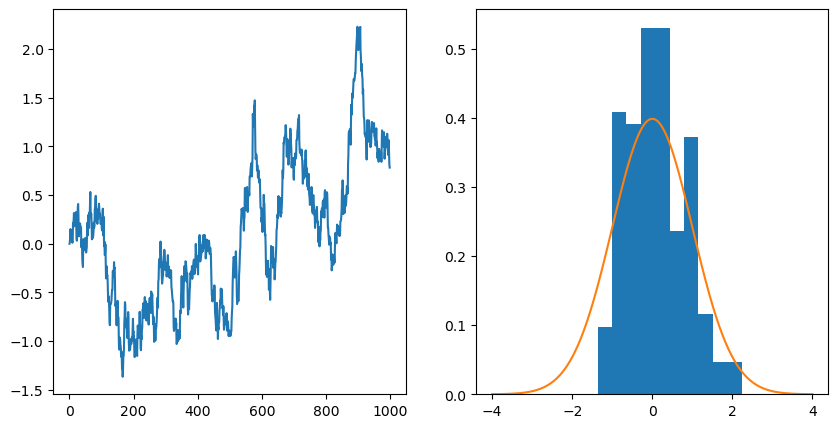

In [26]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# tuning parameter determines how volatile something is - sigma is the tuning parameter


p_x_pdf = lambda x: stats.norm().pdf(x) #target
q_xt_given_xtm1 = lambda x: stats.norm(x, scale=0.1) #creates the perturbation function
# scale is the std dev.

proposal_distribution = q_xt_given_xtm1

m = 1000 # the number of samples
x = np.zeros(m) # initialization for t=0
rejections = 0

#metropolis hastings algo 
for t in range(1,m): #indexing from 1
    x_tilde = proposal_distribution(x[t-1]).rvs()
    acceptance_probability = min(1, p_x_pdf(x_tilde)/p_x_pdf(x[t-1]))
    if stats.uniform().rvs() < acceptance_probability: #rejection based on the probability calculated and shown above
        x[t] = x_tilde
    else:
        x[t] = x[t-1]
        rejections += 1

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x)
ax[1].hist(x, density=True)
x_support = np.linspace(-4,4,301)
ax[1].plot(x_support, p_x_pdf(x_support));

# want to sample from the organge distribution 
# take a lot of samples to overcome the challenge that the samples are dependent
# left shows a highly dependent chain -> can make it less dependent by letting it run faster



## Part B: What is MH?


### Why doesn't this work?


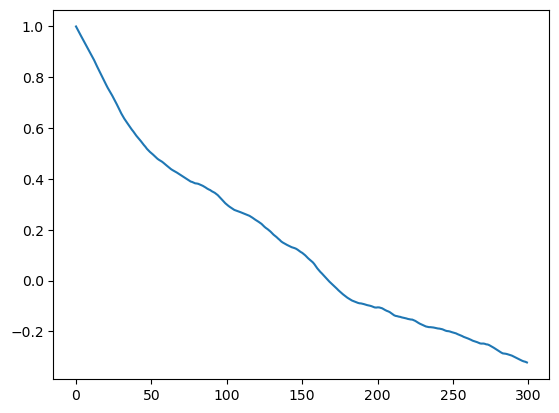

In [2]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]
    
plt.plot(autocorrelations);

#the autocorrelaton decays

### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$

which is based on the relative value of $m$ between
- $\textrm{Var}\left({\sum_{t=1}^m x^{(t)}}\right) = m \sigma^2$ under i.i.d. sampling and the actual 
- $\textrm{Var}\left(\sum_{t=1}^m x^{(t)}\right) = \sum_{t=1}^m \textrm{Var}\left(x^{(t)}\right) + \sum_{t \neq t'} \textrm{Cov}(x^{(t)},x^{(t')}) = m \sigma^2 + \sum_{t \neq t'} \sigma^2 \rho_{t,t'} \approx m \sigma^2+2m \sigma^2 \sum_{k=1}^m\rho_k \approx m \sigma^2+2m \sigma^2 \sum_{k=1}^\infty\rho_k $


In [3]:
m / (1 + 2*autocorrelations[:100].sum())

8.736636136123126

7.277486666566311

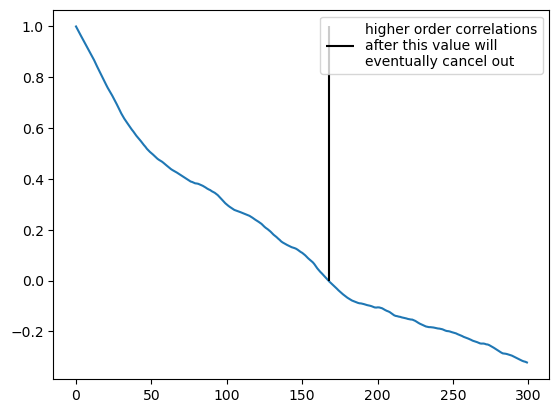

In [4]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]

approximation_stop = (autocorrelations < 0).cumsum()
approximation_stop = approximation_stop*np.arange(K)
approximation_stop = min(approximation_stop[approximation_stop>0])

plt.plot(autocorrelations) 
plt.vlines(approximation_stop, ymin=0, ymax=1, color='k',
           label='higher order correlations\nafter this value will\neventually cancel out')
plt.legend()
# effective sample size
m / (1 + 2*autocorrelations[:approximation_stop].sum())

### Rejection Rate

The **rejection rate** of the **Metropolis Hastings** algorithm given above is something else that we should keep in mind.

#### Q1: Is a high rejection rate benefiicial or detrimental for the effective sample size calculation?

#### Q2: What is the relationship between the proposal distribution and the rejection rate?

In [5]:
rejections/m

0.025

### Why does this work?

> *Changing and hinting with the the notation to begin being suggestive about our purposes...*

If we have a **stationary distribution** $p(\theta \color{gray}{|x})$ then **transition distribution (kernel)** $q$ produces a sample from this **stationary distribution** if the ***Markov chain*** it produces is ***reversible***.

$\require{cancel}
\begin{align*}
p(\theta^{(t)}|\theta^{(t-1)})p(\theta^{(t-1)}\color{gray}{|x}) & = {}  p(\theta^{(t-1)}|\theta^{(t)})p(\theta^{(t)}\color{gray}{|x})\\\\
& \textrm{But is this true if we use a Metropolis-Hastings transition distribution (kernel)?}
\\\\
p(\theta^{(t)}\color{gray}{|x}) & \overset{MH}{=} {} \frac{\alpha_{\textrm{accept prob}}^{\textrm{forward}} q(  \theta^{(t)}| \theta^{(t-1)})}{\alpha_{\textrm{accept prob}}^{\textrm{backward}} q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{\min\left(1,\frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})}\right) q( \theta^{(t)}|\theta^{(t-1)})}{\min\left(1,\frac{p( \theta^{(t-1)}\color{gray}{|x})}{p( \theta^{(t)}\color{gray}{|x})}\frac{q( \theta^{(t)}| \theta^{(t-1)})}{q( \theta^{(t-1)}| \theta^{(t)})}\right) q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\\\
& \textrm{The fractions in the "$\min$" in the numerator or denomenator are reciprocals}\\
& \textrm{thus regardless of if the numerator fraction is equal to, greater than, or less than $1$}\\\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})} \frac{q\theta^{(t)}|\theta^{(t-1)})}{q(\theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x}) \\\\
\xcancel{p( \theta^{(t)}\color{gray}{|x})} & = {} \frac{\xcancel{p(\theta^{(t)}\color{gray}{|x})}}{\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}}\frac{\cancel{q(\theta^{(t-1)}| \theta^{(t)})}}{\cancel{q( \theta^{(t)}|\theta^{(t-1)})}} \frac{\cancel{q\theta^{(t)}|\theta^{(t-1)})}}{\cancel{q(\theta^{(t-1)}|\theta^{(t)})}}\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}\\  \longrightarrow \quad 1 & ={} 1 \quad \textrm{ so the equation is true and reversibility holds}
\end{align*}$

So **Metropolis-Hastings** creates a **reversible Markov Chain** whose **stationary distribution** is the **target** of the **Metropolis-Hastings** algorithm

## Part C: Back to Gibbs sampling

**Gibbs sampling** also creates a **reversible Markov Chain** whereby the samples, forwards or backwards, are from the same **stationary distribution** (which is the **joint posterior distribution** of the (random. variable) parameters of the **full conditional (posterior) distributions**


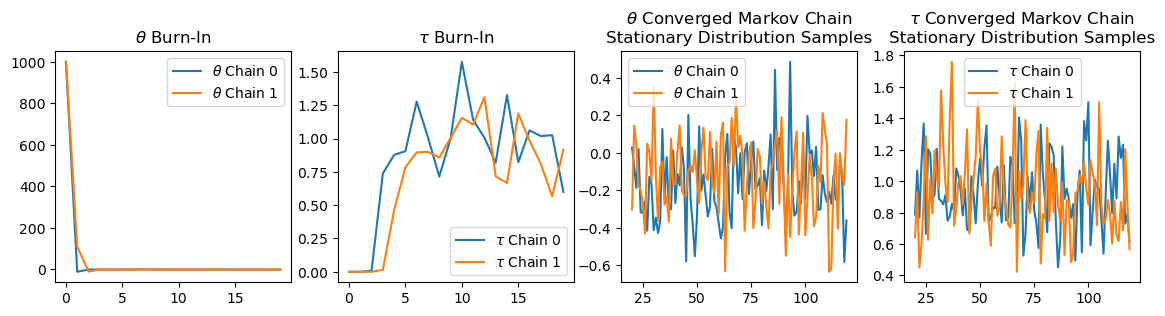

In [6]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau[c,g] = \
        stats.gamma(a=n/2+1, 
                    scale=2/((x-theta[c,g-1])**2).sum()).rvs()
        theta[c,g] = \
        stats.norm(x.mean(), 
                   scale=1/np.sqrt(tau[c,g]*n)).rvs()

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

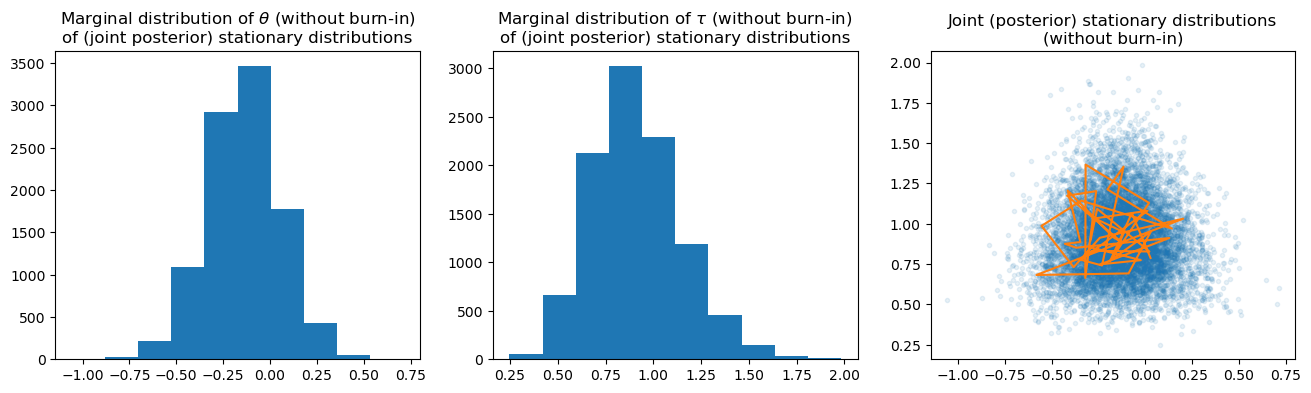

In [7]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distributions")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distributions")
ax[2].set_title("Joint (posterior) stationary distributions\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

## Metropolis within Gibbs

1. All **full conditional distributions** are proportional to the **joint**.
2. A **Metropolis-Hastings** step can sample from a **full conditional** by proposing a sample and accepting it according to the MH acceptance probability.
3. The target density in the MH acceptance probability appears in the numerator and denomenator so it's normalizing constants cancel and all that's needed 

Accepting draws from a ***proposal distribution*** 

$\tilde \theta^{(t)} \sim q(\tilde \theta^{(t)}|\theta^{(t-1)})$

according to 

$\require{cancel}
\theta^{(t)} = \left\{\begin{array}{ll}
\tilde \theta^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})}\frac{q(\theta^{(t-1)}|\tilde \theta^{(t)})}{q(\tilde \theta^{(t)}|\theta^{(t-1)})}\right) = \min\bigg(1,\frac{p(\tilde \theta^{(t)},\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)},\tau^{(t)},\mathbf{x})}\overset{\textrm{if symmetric}}{\cancel{\frac{q(\theta^{(t-1)}|\tilde \theta^{(t)})}{q(\tilde \theta^{(t)}|\theta^{(t-1)})}}^1}\bigg) \\
\theta^{(t-1)} & \text{otherwise}\\\\
\end{array}\right.$

will produce draws from $p(\theta^{(t)}|\tau^{(t)},\mathbf{x})$.

And an analogous **Metropolis within Gibbs** step exists for $\tau^{(t)}$. 


## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


This means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


In [ ]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

In [ ]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


# Q1

In [22]:
# Metropolis within Gibbs
n = 30
x = stats.norm.rvs(size=n)
C,G = 2,1000  # chains, MH withing Gibbs samples
theta = np.zeros([C,G])
tau = np.ones([C,G])  
tau_alpha = 4
tau_scale = 0.5
theta_0 = 0
theta_sd = 3
sigma_theta = 0.5

for c in range(C):
    for g in range(1,G):
        # for tau
        def tau_target(tau_val):
            if tau_val <= 0:
                return 0
            likelihood = np.prod(stats.norm(loc=theta[c, g-1],
                                            scale=1/np.sqrt(tau_val)).pdf(x))
            prior_tau = stats.gamma(a=tau_alpha, scale=tau_scale).pdf(tau_val)
            return likelihood * prior_tau
        
        tau_proposal = stats.gamma(a=tau_alpha, scale=tau_scale)
        tau_star = tau_proposal.rvs()
        
        current_tau = tau[c, g-1]
        ratio_tau = (tau_target(tau_star) / tau_target(current_tau)) * \
                    (tau_proposal.pdf(current_tau) / tau_proposal.pdf(tau_star))
        
        tau_acceptance_probability = min(1, ratio_tau)

        if stats.uniform().rvs() < tau_acceptance_probability:
            tau[c,g] = tau_star
        else:
            tau[c,g] = tau[c,g-1]

        # for theta
        def theta_target(theta_val):
            likelihood = np.prod(stats.norm(loc=theta_val, scale=1/np.sqrt(tau[c, g])).pdf(x))
            prior_theta = stats.norm(loc=theta_0, scale=theta_sd).pdf(theta_val)
            return likelihood * prior_theta
        
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=sigma_theta)
        theta_star = theta_proposal.rvs()
        
        current_theta = theta[c, g-1]
        ratio_theta = (theta_target(theta_star) / theta_target(current_theta)) * \
                      (theta_proposal.pdf(current_theta) / theta_proposal.pdf(theta_star))
        theta_acceptance_probability = min(1, ratio_theta)
        
        if stats.uniform().rvs() < theta_acceptance_probability:
            theta[c,g] = theta_star
        else:
            theta[c,g] = theta[c,g-1]

#to provide a demonstration of bayesian inference
burn = 20 
posterior_theta = theta[:, burn:].flatten() 
posterior_tau = tau[:, burn:].flatten()    

# 95% credible intervals
theta_credible_interval = np.percentile(posterior_theta, [2.5, 97.5])
tau_credible_interval = np.percentile(posterior_tau, [2.5, 97.5])

print("95% Credible Interval for θ:", theta_credible_interval)
print("95% Credible Interval for τ:", tau_credible_interval)

95% Credible Interval for θ: [-0.49932398  0.26735773]
95% Credible Interval for τ: [0.6464557  1.61578618]


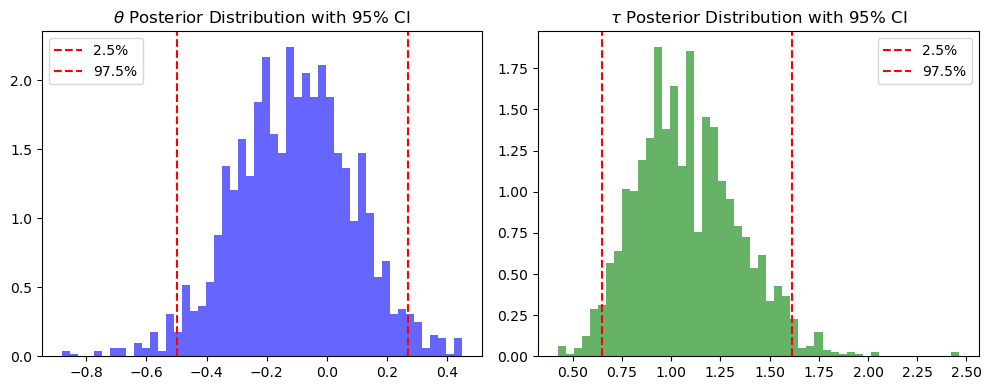

In [23]:
#visualize the credible intervals
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(posterior_theta, bins=50, density=True, alpha=0.6, color='blue')
ax[0].axvline(theta_credible_interval[0], color='red', linestyle='--', label='2.5%')
ax[0].axvline(theta_credible_interval[1], color='red', linestyle='--', label='97.5%')
ax[0].set_title("$\\theta$ Posterior Distribution with 95% CI")
ax[0].legend()

ax[1].hist(posterior_tau, bins=50, density=True, alpha=0.6, color='green')
ax[1].axvline(tau_credible_interval[0], color='red', linestyle='--', label='2.5%')
ax[1].axvline(tau_credible_interval[1], color='red', linestyle='--', label='97.5%')
ax[1].set_title("$\\tau$ Posterior Distribution with 95% CI")
ax[1].legend()

plt.tight_layout()
plt.show()


Now to compare with the previous Gibbs sampler from the last HW:

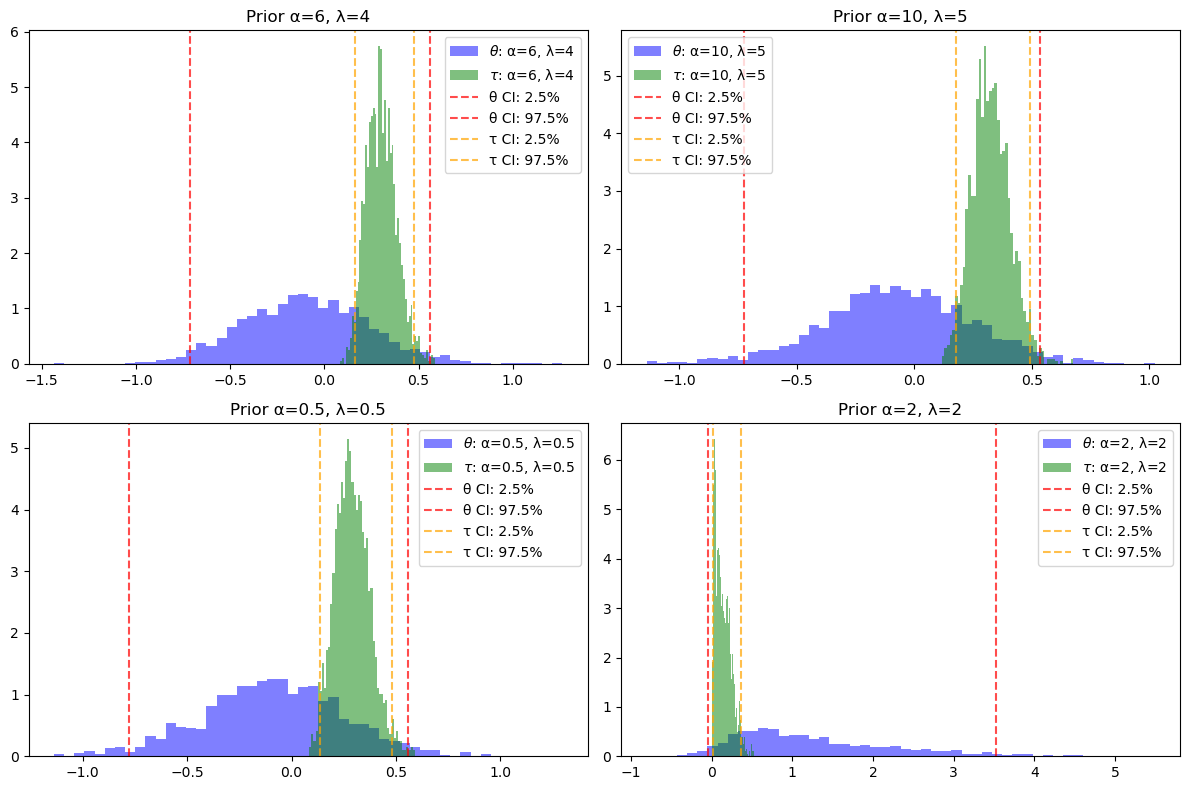

In [24]:
def gibbs_sampler(alpha, lmbda, theta_0, tau_0, n, x, C =2,G=1000, burn=20):

    theta,tau = np.zeros([C,G]),np.zeros([C,G])
    theta[:,0] = 1000  # initialization
    tau[:, 0] = 1 

    for c in range(C):
        for g in range(1,G):
            # https://en.wikipedia.org/wiki/Gamma_distribution
            shape = (n + alpha) /2
            scale = 1/(np.sum((x - theta[c, g - 1])**2) + lmbda) / 2
            tau[c,g] = stats.gamma(a=shape, scale=scale).rvs()
        
            #update theta
            theta[c, g] = stats.norm((tau[c, g] * np.sum(x) + tau_0 * theta_0) / (tau[c, g] * n + tau_0), scale=np.sqrt(1 / (tau[c, g] * n + tau_0))).rvs()

    #to provide a demonstration of bayesian inference
    posterior_theta = theta[:, burn:].flatten() 
    posterior_tau = tau[:, burn:].flatten()    

    # 95% credible intervals
    theta_credible_interval = np.percentile(posterior_theta, [2.5, 97.5])
    tau_credible_interval = np.percentile(posterior_tau, [2.5, 97.5])
    
    return posterior_theta, posterior_tau, theta_credible_interval, tau_credible_interval

n = 30
m = 0
s = 1
x = stats.norm(loc=m, scale=s).rvs(size=n)

# try different priors to compare
prior_settings = [
    {"alpha": 6, "lmbda": 4, "theta_0": 0, "tau_0": 1},
    {"alpha": 10, "lmbda": 5, "theta_0": 0.2, "tau_0": 1},  
    {"alpha": 0.5, "lmbda": 0.5, "theta_0": 0, "tau_0": 1}, 
    {"alpha": 2, "lmbda": 2, "theta_0": 5, "tau_0": 1}, 
]

# gibbs sampler for each
results = []
for setting in prior_settings:
    result = gibbs_sampler(**setting, n=n, x=x)
    results.append((setting, *result))  

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, (setting, posterior_theta, posterior_tau, theta_ci, tau_ci) in enumerate(results):
    row, col = divmod(i, 2)  
    ax[row, col].hist(posterior_theta, bins=50, density=True, alpha=0.5, color='blue', label=f"$\\theta$: α={setting['alpha']}, λ={setting['lmbda']}")
    ax[row, col].hist(posterior_tau, bins=50, density=True, alpha=0.5, color='green', label=f"$\\tau$: α={setting['alpha']}, λ={setting['lmbda']}")
    ax[row, col].axvline(theta_ci[0], color='red', linestyle='--', alpha=0.7, label='θ CI: 2.5%')
    ax[row, col].axvline(theta_ci[1], color='red', linestyle='--', alpha=0.7, label='θ CI: 97.5%')
    ax[row, col].axvline(tau_ci[0], color='orange', linestyle='--', alpha=0.7, label='τ CI: 2.5%')
    ax[row, col].axvline(tau_ci[1], color='orange', linestyle='--', alpha=0.7, label='τ CI: 97.5%')
    ax[row, col].set_title(f"Prior α={setting['alpha']}, λ={setting['lmbda']}")

for a in ax.flatten():
    a.legend()

plt.tight_layout()
plt.show()


i In the Metropolis within Gibbs sampler we want to draw samples from the joint posterior of some unknown $\theta$ and $\tau$ using known observed data. It does this by testing values for $\tau$ and $\theta$ and either accepting or rejecting them based on a calculated rate.

Our known data follows a normal distribution with a Gamma prior for $\tau$ and a normal prior for $\theta$. Then we consider the joint posterior $(\theta, \tau)$ to calculate their likelihoods. To predict the values for $\tau$ and $\theta$ we propose new values for each one at a time (so one is fixed while we change the other). The values are then either accepted or rejected. This is done many times until the joint posterior is estimated.

Let the Gibbs Sampler from the previous week's homework be refered to as the standard Gibbs. In the standard Gibbs sampler, $\theta$ and $\tau$ are updated differently, they are sampled directly from the full conditionals. This also why the standard code doesn't have an if else block for acceptance or rejection; the samples are exact. 

Using Metropolis within Gibbs makes things different since we not longer using the full conditionals. This algorithm introduces a proposal distribution that is easy to sample from. There is then an acceptance ratio whch is calculated by dividing the unnormalized posterior of the new state to that of the old. 

Both methods are similar in the way that they take samples from the joint posterior but they just do it in different ways.

# Q2

In [28]:
from scipy.stats import truncnorm, cauchy

# Adjusted Metropolis within Gibbs
n = 30
x = stats.norm.rvs(size=n)
C,G = 2,1000  # chains, MH withing Gibbs samples
theta = np.zeros([C,G])
tau = np.ones([C,G])  
tau_alpha = 4
tau_scale = 0.5
theta_scale = 1.0
theta_0 = 0
theta_sd = 3
sigma_theta = 0.5
tau_sigma = 0.3 

def tau_proposal_dist(current_tau):
    a = -current_tau / tau_sigma
    b = np.inf
    return truncnorm(a=a, b=b, loc=current_tau, scale=tau_sigma)


def tau_target(tau_val):
    if tau_val <= 0:
        return 0
    likelihood = np.prod(stats.norm(loc=theta[c, g-1],
                                            scale=1/np.sqrt(tau_val)).pdf(x))
    prior_tau = stats.gamma(a=tau_alpha, scale=tau_scale).pdf(tau_val)
    return likelihood * prior_tau


def theta_target(theta_val):
    likelihood = np.prod(stats.norm(loc=theta_val, scale=1/np.sqrt(tau[c, g])).pdf(x))
    prior_theta = cauchy(loc=theta_0, scale=theta_sd).pdf(theta_val)
    return likelihood * prior_theta


for c in range(C):
    for g in range(1,G):
        # for tau
        current_tau = tau[c, g-1]

        tau_proposal = tau_proposal_dist(current_tau)
        tau_star = tau_proposal.rvs()
        ratio_tau = (tau_target(tau_star) / tau_target(current_tau)) * \
                    (tau_proposal.pdf(current_tau) / tau_proposal.pdf(tau_star))
        
        tau_acceptance_probability = min(1, ratio_tau)

        if stats.uniform().rvs() < tau_acceptance_probability:
            tau[c,g] = tau_star
        else:
            tau[c,g] = tau[c,g-1]

        # for theta
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=sigma_theta)
        theta_star = theta_proposal.rvs()
        
        current_theta = theta[c, g-1]
        ratio_theta = (theta_target(theta_star) / theta_target(current_theta)) * \
                      (theta_proposal.pdf(current_theta) / theta_proposal.pdf(theta_star))
        theta_acceptance_probability = min(1, ratio_theta)
        
        if stats.uniform().rvs() < theta_acceptance_probability:
            theta[c,g] = theta_star
        else:
            theta[c,g] = theta[c,g-1]

#to provide a demonstration of bayesian inference
burn = 20 
posterior_theta = theta[:, burn:].flatten() 
posterior_tau = tau[:, burn:].flatten()    

# 95% credible intervals
theta_credible_interval = np.percentile(posterior_theta, [2.5, 97.5])
tau_credible_interval = np.percentile(posterior_tau, [2.5, 97.5])

print("95% Credible Interval for θ:", theta_credible_interval)
print("95% Credible Interval for τ:", tau_credible_interval)

95% Credible Interval for θ: [-0.56158596  0.0199994 ]
95% Credible Interval for τ: [0.87094175 3.00017113]


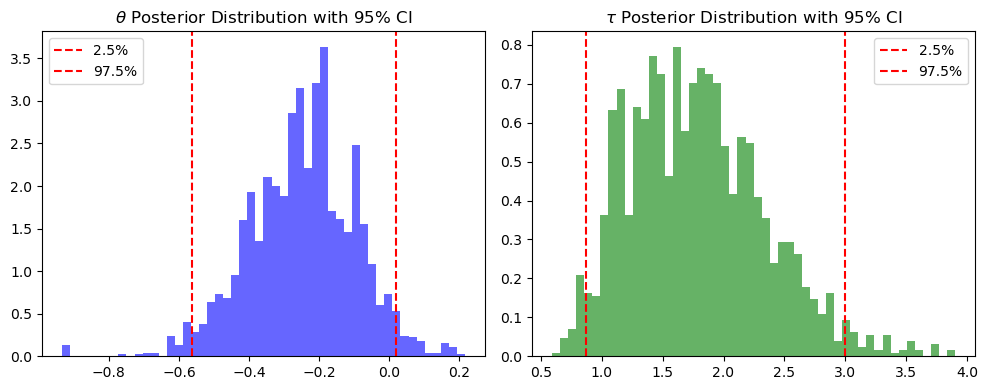

In [29]:
#visualize the credible intervals
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(posterior_theta, bins=50, density=True, alpha=0.6, color='blue')
ax[0].axvline(theta_credible_interval[0], color='red', linestyle='--', label='2.5%')
ax[0].axvline(theta_credible_interval[1], color='red', linestyle='--', label='97.5%')
ax[0].set_title("$\\theta$ Posterior Distribution with 95% CI")
ax[0].legend()

ax[1].hist(posterior_tau, bins=50, density=True, alpha=0.6, color='green')
ax[1].axvline(tau_credible_interval[0], color='red', linestyle='--', label='2.5%')
ax[1].axvline(tau_credible_interval[1], color='red', linestyle='--', label='97.5%')
ax[1].set_title("$\\tau$ Posterior Distribution with 95% CI")
ax[1].legend()

plt.tight_layout()
plt.show()

It is not necessary to determine the full conditionals when doing Metropolis Hasting since you only need the unnormaliezd target density. Unlike the standard Gibbs sampling you do not sample directly from the distributions of the unknown variables. Instead values are proposed and either accepted/rejected based on the ratio between the un-normalized densities. In other words the normalizing constant isn't needed so we don't need the full conditionals. 

# Q3

Let
$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>We want to show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

From the given information, the acceptance probability is
\begin{align*}
\alpha &= min(1, \frac {p(\tilde{x})q(x|\tilde{x})} {p({x})q(\tilde{x}|{x})})\\
& = min(1, \frac {p(\tilde{x})}{p(x)})
\end{align*}

Then we have 
\begin{align*}
K &= Pr(X^{t+1} = x' | X^{(t)} = x)\\
& = q(x'|x)\alpha \quad \quad \text{when $x'\neq x$}\\
& = 1 - \sum_{\tilde{x} \neq x} K
\end{align*}

Consider the two cases

Case 1: Assume $x=0$, the proposed value is 1 with probability 0.5. Then we have

$ \\ \alpha = min(1,2) \Rightarrow K = 0.5 \times1 = 0.5$

If the proposed value is 0 and probabilty is 0.5 we get

$\\ \alpha = min(1,1) \Rightarrow K = 1 \times0.5 = 0.5$

$\\\\$

Case 2: Assume $x=1$, the proposed value is 1 with probability 0.5. Then we have

$ \\ \alpha = min(1,1) \Rightarrow K = 0.5 \times1 = 0.5$

If the proposed value is 0 and probabilty is 0.5 we get

$\\ \\ \alpha = min(1,0.5) \Rightarrow K = 0.5 \times0.5 = 0.25$

But if reject the proposal of 0 then we have 

$K = 0.5 + 0.25 = 0.75$

Now we have 
\begin{align*}
K = \begin{pmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{pmatrix}
\end{align*}
as needed.
